In [1]:
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pycytominer import aggregate

%matplotlib inline  

In [2]:
# Set data input folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)
if not os.path.exists(os.path.join(output_folder,"figure_panels")):
    os.makedirs(os.path.join(output_folder,"figure_panels"), exist_ok=True)

In [3]:
#Load the barcode information from Funk et al 2022 manuscript and organize the data
barcodes_df = pd.read_excel(os.path.join(input_folder,'NIHMS1924969-supplement-Table_S1.xlsx'),skiprows=1)
barcodes_df = barcodes_df[['Gene Symbol','sgRNA sequence']]
barcodes_df = barcodes_df.rename(columns={'Gene Symbol':'gene','sgRNA sequence':'sgRNA'})

all_genes_list = list(barcodes_df.iloc[:,0].unique())
nontargeting_genes_list = [gene for gene in all_genes_list if gene.startswith('non')]

barcodes_df.loc[barcodes_df['gene'].isin(nontargeting_genes_list), 'gene'] = 'nontargeting'
barcodes_df

,gene,sgRNA
0,RGPD5,ACGGTGATGCCAAACTAGAG
1,RGPD5,GAAATTATCTGACAAAGACC
2,RGPD5,CACCTCGATGGACAGAAGAT
3,FAM25C,TGAAGCCATAAAGAAAGCCC
4,FAM25C,CTGTTCAGTTCATGCCGTGG
...,...,...
20440,OBSCN,GCCCAAGGTGGTGTTTGCTA
20441,MUC16,CCTCAGTAATAGTACCAGTG
20442,MUC16,ACACAGTTGAAACTAGTCGG
20443,MUC16,AATGGATACCACCTCCACCA


In [4]:
# Create a dictionary with guides as keys and associated genes as values
all_guides_list = list(barcodes_df.iloc[:,1].unique())
guide_to_gene_dic = {}

for guide in all_guides_list:
    temp_df = barcodes_df.query('sgRNA == @guide')
    gene = list(temp_df['gene'])[0]
    guide_to_gene_dic[guide] = gene

In [4]:
# Load the metadata from the single cell profiles: Harvard Dataverse: https://doi.org/10.7910/DVN/VYKTI5
# Before running, see README for information about downloading the input data

input_features_list = ['gene_symbol_0']

ddf = dd.read_parquet('interphase-reclassified_cp_phenotype_normalized.parquet',engine='pyarrow',columns=input_features_list)
ddf = ddf.reset_index()
ddf

,sgRNA_0,gene_symbol_0
npartitions=3027,,
,object,object
,...,...
...,...,...
,...,...
,...,...


In [5]:
# Perform compute on the lazy ddf
selected_sc_profiles = ddf.compute(scheduler='processes', num_workers = 16)
selected_sc_profiles

,sgRNA_0,gene_symbol_0
0,AAAACAAAAGCAGATGACCG,CCNT1
1,AAAACAAAAGCAGATGACCG,CCNT1
2,AAAACAAAAGCAGATGACCG,CCNT1
3,AAAACAAAAGCAGATGACCG,CCNT1
4,AAAACAAAAGCAGATGACCG,CCNT1
...,...,...
3169,TTTTGCATGCTTTTACACCT,ZNF738
3170,TTTTGCATGCTTTTACACCT,ZNF738
3171,TTTTGCATGCTTTTACACCT,ZNF738
3172,TTTTGCATGCTTTTACACCT,ZNF738


In [6]:
# count number of cell per guide and organize the data
sc_counts_df = pd.DataFrame(selected_sc_profiles.groupby('sgRNA_0').size()).rename(columns = {0:'count'})
sc_counts_df['gene'] = np.nan
sc_counts_df = sc_counts_df.reset_index()
for i in range(len(sc_counts_df)):
    try:
        sc_counts_df.iloc[i,2] = guide_to_gene_dic[str(sc_counts_df.iloc[i,0])]
    except:
        print(str(sc_counts_df.iloc[i,0]), 'Didnt work!')

sc_counts_df

,sgRNA_0,count,gene
0,AAAACAAAAGCAGATGACCG,1994,CCNT1
1,AAAACAAAGGTAGAACATGG,1825,GTF2E2
2,AAAACAACTTGGTCATAGTG,2485,ELP3
3,AAAACAAGTCCAGCTAGAGC,1057,GOLGA6C
4,AAAACACATCAGTATAACAT,2213,RHOA
...,...,...,...
20440,TTTGTTTGGATTGCTTCAAG,1149,NEPRO
20441,TTTGTTTTAAATGTGATCCT,1807,UBE2L5
20442,TTTTCTTCTAGACTACTCGA,406,ELL
20443,TTTTGAAAGAGTTAACAGAG,1795,WASHC2C


In [7]:
# filter out the genes to select genes with 4 guides at 1000 representation
sc_counts_df['n_guides'] = np.nan
for guide in all_guides_list:
    gene = list(sc_counts_df.loc[sc_counts_df['sgRNA_0']== guide,'gene'])[0]
    df_temp = sc_counts_df.query('gene == @gene')
    sc_counts_df.loc[sc_counts_df['sgRNA_0']== guide,'n_guides'] = len(df_temp)
    
sc_counts_df_1000 = sc_counts_df.query('count > 1000')
all_guides_list_1000 = list(sc_counts_df_1000.sgRNA_0.unique())
for guide in all_guides_list_1000:
    gene = list(sc_counts_df_1000.loc[sc_counts_df_1000['sgRNA_0']== guide,'gene'])[0]
    df_temp = sc_counts_df_1000.query('gene == @gene')
    sc_counts_df_1000.loc[sc_counts_df_1000['sgRNA_0']== guide,'n_guides'] = len(df_temp)
    
sc_counts_df_1000_4_guides = sc_counts_df_1000.query('n_guides >= 4')
sc_counts_df_1000_4_guides

,sgRNA_0,count,gene,n_guides
0,AAAACAAAAGCAGATGACCG,1994,CCNT1,4.0
1,AAAACAAAGGTAGAACATGG,1825,GTF2E2,4.0
5,AAAACAGGACGATGTGCGGC,2364,nontargeting,225.0
6,AAAACATCATCTCCTACGCA,2604,OR8A1,4.0
7,AAAACATCGACCGAAAGCGT,2686,nontargeting,225.0
...,...,...,...,...
20427,TTTGTCTCTAGTACTGAACC,1501,GTF2H4,4.0
20435,TTTGTTATTGCAGAATGTGA,1472,PPP4R2,4.0
20440,TTTGTTTGGATTGCTTCAAG,1149,NEPRO,4.0
20443,TTTTGAAAGAGTTAACAGAG,1795,WASHC2C,4.0


In [8]:
# Save the list of genes with all 4 guides at 1000 representation or higher for next steps 
sc_counts_df_1000_4_guides.to_csv('Funk_et_al_2022_genes_with_4_guide_above_1000_cells.csv')

In [14]:
# Load the features from Supplement-Table_S2 from Funk et al. 2022 manuscript and organize the data
features_df = pd.read_excel(os.path.join(input_folder,'Funk_et_al_Supplement-Table_S2.xlsx'), sheet_name='(B) Extracted image features',skiprows=1)
selected_features_df = features_df[features_df["Used in interphase PHATE analysis"] == 1]
selected_features_list = list(selected_features_df.feature)
input_features_list = ['gene_symbol_0'] + selected_features_list
len(input_features_list)

476

In [3]:
# Load the single cell profiles: Harvard Dataverse: https://doi.org/10.7910/DVN/VYKTI5
ddf = dd.read_parquet('interphase-reclassified_cp_phenotype_normalized.parquet',engine='pyarrow',columns=input_features_list)
ddf = ddf.reset_index()
ddf

,sgRNA_0,gene_symbol_0,cell_dapi_int,cell_dapi_min,cell_dapi_mass_displacement,cell_dapi_int_edge,cell_tubulin_mean,cell_tubulin_std,cell_tubulin_min,cell_tubulin_mass_displacement,cell_tubulin_lower_quartile,cell_tubulin_mean_edge,cell_tubulin_std_edge,cell_gh2ax_min,cell_gh2ax_mass_displacement,cell_gh2ax_mad,cell_gh2ax_int_edge,cell_gh2ax_mean_edge,cell_gh2ax_std_edge,cell_phalloidin_min,cell_phalloidin_mass_displacement,cell_phalloidin_median,cell_phalloidin_mean_edge,nucleus_dapi_int,nucleus_dapi_mean,nucleus_dapi_mass_displacement,nucleus_dapi_int_edge,nucleus_tubulin_mass_displacement,nucleus_tubulin_int_edge,nucleus_tubulin_std_edge,nucleus_gh2ax_int,nucleus_gh2ax_std,nucleus_gh2ax_mass_displacement,nucleus_gh2ax_median,nucleus_gh2ax_std_edge,nucleus_phalloidin_mass_displacement,nucleus_phalloidin_int_edge,cell_dapi_mean_frac_0,cell_dapi_mean_frac_2,cell_dapi_mean_frac_3,cell_dapi_radial_cv_0,cell_dapi_radial_cv_1,cell_dapi_radial_cv_2,cell_dapi_radial_cv_3,cell_dapi_weighted_hu_moments_1,cell_dapi_weighted_hu_moments_3,cell_dapi_weighted_hu_moments_4,cell_dapi_weighted_hu_moments_5,cell_dapi_weighted_hu_moments_6,cell_tubulin_frac_at_d_0,cell_tubulin_mean_frac_0,cell_tubulin_mean_frac_2,cell_tubulin_mean_frac_3,cell_tubulin_radial_cv_0,cell_tubulin_radial_cv_1,cell_tubulin_weighted_hu_moments_1,cell_tubulin_weighted_hu_moments_2,cell_tubulin_weighted_hu_moments_3,cell_tubulin_weighted_hu_moments_4,cell_tubulin_weighted_hu_moments_5,cell_tubulin_weighted_hu_moments_6,cell_gh2ax_mean_frac_1,cell_gh2ax_mean_frac_2,cell_gh2ax_radial_cv_0,cell_gh2ax_radial_cv_1,cell_gh2ax_radial_cv_2,cell_gh2ax_weighted_hu_moments_2,cell_gh2ax_weighted_hu_moments_3,cell_gh2ax_weighted_hu_moments_4,cell_gh2ax_weighted_hu_moments_5,cell_gh2ax_weighted_hu_moments_6,cell_phalloidin_frac_at_d_0,cell_phalloidin_frac_at_d_1,cell_phalloidin_frac_at_d_3,cell_phalloidin_mean_frac_0,cell_phalloidin_mean_frac_1,cell_phalloidin_mean_frac_2,cell_phalloidin_mean_frac_3,cell_phalloidin_radial_cv_2,cell_phalloidin_radial_cv_3,cell_phalloidin_weighted_hu_moments_1,cell_phalloidin_weighted_hu_moments_2,cell_phalloidin_weighted_hu_moments_3,cell_phalloidin_weighted_hu_moments_4,cell_phalloidin_weighted_hu_moments_5,cell_phalloidin_weighted_hu_moments_6,nucleus_dapi_frac_at_d_0,nucleus_dapi_mean_frac_1,nucleus_dapi_mean_frac_2,nucleus_dapi_radial_cv_0,nucleus_dapi_radial_cv_1,nucleus_dapi_radial_cv_2,nucleus_dapi_radial_cv_3,nucleus_dapi_weighted_hu_moments_1,nucleus_dapi_weighted_hu_moments_2,nucleus_dapi_weighted_hu_moments_3,nucleus_dapi_weighted_hu_moments_4,nucleus_dapi_weighted_hu_moments_5,nucleus_dapi_weighted_hu_moments_6,nucleus_tubulin_frac_at_d_0,nucleus_tubulin_frac_at_d_1,nucleus_tubulin_frac_at_d_3,nucleus_tubulin_mean_frac_0,nucleus_tubulin_mean_frac_2,nucleus_tubulin_mean_frac_3,nucleus_tubulin_radial_cv_0,nucleus_tubulin_radial_cv_2,nucleus_tubulin_weighted_hu_moments_2,nucleus_tubulin_weighted_hu_moments_3,nucleus_tubulin_weighted_hu_moments_4,nucleus_tubulin_weighted_hu_moments_5,nucleus_tubulin_weighted_hu_moments_6,nucleus_gh2ax_frac_at_d_0,nucleus_gh2ax_frac_at_d_1,nucleus_gh2ax_mean_frac_0,nucleus_gh2ax_mean_frac_2,nucleus_gh2ax_mean_frac_3,nucleus_gh2ax_radial_cv_0,nucleus_gh2ax_radial_cv_1,nucleus_gh2ax_radial_cv_2,nucleus_gh2ax_radial_cv_3,nucleus_gh2ax_weighted_hu_moments_1,nucleus_gh2ax_weighted_hu_moments_2,nucleus_gh2ax_weighted_hu_moments_3,nucleus_gh2ax_weighted_hu_moments_4,nucleus_gh2ax_weighted_hu_moments_5,nucleus_gh2ax_weighted_hu_moments_6,nucleus_phalloidin_frac_at_d_1,nucleus_phalloidin_frac_at_d_2,nucleus_phalloidin_mean_frac_1,nucleus_phalloidin_mean_frac_2,nucleus_phalloidin_radial_cv_0,nucleus_phalloidin_radial_cv_1,nucleus_phalloidin_weighted_hu_moments_1,nucleus_phalloidin_weighted_hu_moments_2,nucleus_phalloidin_weighted_hu_moments_3,nucleus_phalloidin_weighted_hu_moments_4,nucleus_phalloidin_weighted_hu_moments_5,nucleus_phalloidin_weighted_hu_moments_6,cell_dapi_pftas_5,cell_dapi_pftas_6,cell_dapi_pftas_8,cell_

In [4]:
# Load the list of genes with all 4 guides at 1000 representation or higher if staritng from here
#sc_counts_df_1000_4_guides = pd.read_csv('Funk_et_al_2022_genes_with_4_guide_above_1000_cells.csv')
selected_genes_list = list(sc_counts_df_1000_4_guides.gene.unique())
len(selected_genes_list)

1701

In [5]:
selected_sc_profiles = ddf[ddf['gene_symbol_0'].isin(selected_genes_list)]   
selected_sc_profiles = selected_sc_profiles.compute(scheduler='processes', num_workers = 16)
selected_sc_profiles

,sgRNA_0,gene_symbol_0,cell_dapi_int,cell_dapi_min,cell_dapi_mass_displacement,cell_dapi_int_edge,cell_tubulin_mean,cell_tubulin_std,cell_tubulin_min,cell_tubulin_mass_displacement,...,nucleus_zernike_9_7,nucleus_zernike_9_9,nucleus_hu_moments_2,nucleus_hu_moments_3,nucleus_hu_moments_4,nucleus_hu_moments_5,nucleus_hu_moments_6,cell_percent_touching_1,cell_angle_between_neighbors,nucleus_angle_between_neighbors
0,AAAACAAAAGCAGATGACCG,CCNT1,6.530656,0.586513,0.516086,0.069125,0.700665,0.487563,0.691784,0.837372,...,-0.527046,0.064559,0.754538,1.034420,-34.138506,-14.483641,18.723596,0.229177,-1.209646,-0.929039
1,AAAACAAAAGCAGATGACCG,CCNT1,1.440534,0.674490,0.236631,-0.499575,0.807878,0.386532,-0.190241,1.504697,...,-0.139425,-0.627111,0.448880,0.046461,-0.089249,0.241944,-2.111931,0.674490,-0.614047,-0.133376
2,AAAACAAAAGCAGATGACCG,CCNT1,1.335892,0.381233,-0.777934,-0.795877,0.478737,-0.736345,1.089560,-0.478854,...,0.173494,1.128232,0.972674,0.570585,-11.679177,-3.536732,4.301999,-0.277536,-0.455723,-0.063091
3,AAAACAAAAGCAGATGACCG,CCNT1,-0.571834,0.762467,1.721087,0.667687,1.183416,0.435417,1.262506,0.560123,...,-0.665011,0.831053,1.062004,0.620849,10.871691,2.147503,-10.686252,0.245982,0.902865,-0.485907
4,AAAACAAAAGCAGATGACCG,CCNT1,0.354348,-0.087977,1.723972,0.013447,-0.235605,0.114335,0.138357,-0.250085,...,-0.786019,0.098787,-0.650640,-0.274237,0.393699,0.169571,0.122355,-0.168535,0.911590,0.217383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169,TTTTGCATGCTTTTACACCT,ZNF738,1.226953,0.458653,-0.073044,1.957084,0.268096,0.165182,-0.082720,-0.734372,...,1.010829,-1.188768,0.998085,1.205989,55.757971,17.073436,47.975968,-0.398199,0.485610,1.066683
3170,TTTTGCATGCTTTTACACCT,ZNF738,0.059092,-0.458653,-1.124815,-0.453222,-0.952088,-0.934603,0.349971,0.154525,...,-2.542983,-0.878782,0.730635,0.195093,3.465408,1.278735,1.575274,0.674490,-0.277648,0.329882
3171,TTTTGCATGCTTTTACACCT,ZNF738,-0.272363,-0.890326,-0.131758,-1.171286,-1.355168,-1.101951,0.222709,-0.649738,...,-0.726075,1.074950,0.610392,-1.595551,-0.011077,-0.026062,-0.025182,-2.965929,-0.318723,-0.035714
3172,TTTTGCATGCTTTTACACCT,ZNF738,-0.908260,1.473885,-1.365738,-0.687783,0.197097,-0.241489,0.739006,-0.031903,...,-1.970284,0.513909,-1.634514,-1.068912,0.015739,0.099553,-0.013264,0.000000,0.169757,0.392788


In [6]:
selected_guides_list = list((selected_sc_profiles.sgRNA_0.unique()))

subsample_ns = [100,200,300,400,500,750,1000]
subsample_dfs_dictionary = {} 
for n in subsample_ns:
    df_list_n = []
    for guide in selected_guides_list:
        df_temp = selected_sc_profiles.query('sgRNA_0 == @guide')
        if len(df_temp)<n:
            continue
        df_temp_sample = df_temp.sample(n=n,random_state=42)
        df_list_n.append(df_temp_sample)
    df_n = pd.concat(df_list_n)
    
    aggregate_df_n = aggregate(
        population_df=df_n,
        strata=['gene_symbol_0','sgRNA_0'],
        features=selected_features_list,
        operation='median'
    )
    subsample_dfs_dictionary[n]=aggregate_df_n
    aggregate_df_n.to_csv(os.path.join(output_folder,f'Funk_et_al_2022_data_subsample_aggregated_{n}_cells.csv'),index=False)
    print(f'profiles at {n} representation level are aggregated.')
subsample_dfs_dictionary[subsample_ns[0]]

profiles at 100 representation level are aggregated.
profiles at 200 representation level are aggregated.
profiles at 300 representation level are aggregated.
profiles at 400 representation level are aggregated.
profiles at 500 representation level are aggregated.
profiles at 750 representation level are aggregated.
profiles at 1000 representation level are aggregated.


,gene_symbol_0,sgRNA_0,cell_dapi_int,cell_dapi_min,cell_dapi_mass_displacement,cell_dapi_int_edge,cell_tubulin_mean,cell_tubulin_std,cell_tubulin_min,cell_tubulin_mass_displacement,...,nucleus_zernike_9_7,nucleus_zernike_9_9,nucleus_hu_moments_2,nucleus_hu_moments_3,nucleus_hu_moments_4,nucleus_hu_moments_5,nucleus_hu_moments_6,cell_percent_touching_1,cell_angle_between_neighbors,nucleus_angle_between_neighbors
0,AAGAB,AGCAGACATCAATCTATGTG,-0.029760,-0.025942,0.287865,0.253405,-0.163822,-0.074571,-0.143722,0.047165,...,0.363088,0.135849,0.120396,0.098822,0.037616,0.096447,0.000002,-0.029485,0.056408,0.171018
1,AAGAB,CAAGAATGGTGCATCAAACA,-0.040614,0.148548,-0.295465,0.176672,-0.071965,-0.071948,0.015874,-0.007859,...,-0.032596,0.016085,0.002309,-0.071015,0.000052,0.045550,0.001282,-0.016257,0.234133,0.161967
2,AAGAB,CACTACATTGGACCACACAT,-0.145140,0.026980,0.136217,0.007244,0.118691,0.035967,0.149207,-0.057625,...,-0.108929,-0.091211,0.186999,0.179377,0.026563,0.111771,0.000763,0.000000,0.179801,-0.108280
3,AAGAB,GCCATGAGGAGACACTATCA,0.020091,-0.077826,-0.197085,0.139518,-0.178547,-0.158263,-0.100885,0.097945,...,0.050192,-0.101378,0.233665,0.320504,0.329263,0.153913,-0.020278,-0.116706,-0.028810,0.040774
4,AATF,AAACCACCTCTAGAAAAGCA,-0.303294,-0.160958,0.072690,-0.013826,-0.085484,-0.050303,-0.094806,-0.007352,...,0.083574,-0.011554,-0.068164,-0.056352,-0.007498,-0.022181,-0.000217,-0.016395,0.059094,-0.002604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7045,nontargeting,TTCGGAACTTACTCAGGGTA,-0.111918,0.162137,0.131565,-0.055747,-0.008162,-0.056397,-0.086846,0.025793,...,0.094962,0.014170,-0.199145,-0.233926,0.030018,0.083211,0.008320,0.093676,0.150858,0.105079
7046,nontargeting,TTCGTGGTAGGTATAACTAT,0.115553,-0.029030,-0.096303,-0.080117,-0.111217,0.105396,0.024860,-0.202036,...,-0.062276,0.055856,-0.277724,-0.096327,0.010077,0.017051,-0.013550,-0.111417,0.192090,0.008591
7047,nontargeting,TTCTAAGCCACGTGTGGTAC,0.058136,0.120445,-0.031691,0.027999,0.053742,-0.020799,-0.040594,0.097641,...,0.102644,0.044776,-0.242476,-0.089330,-0.001740,0.015934,0.001065,0.000000,0.125957,0.104119
7048,nontargeting,TTGTCCGTGACCCTGATTAA,-0.127086,-0.092166,0.085811,-0.087144,0.324173,0.037203,0.196931,-0.057065,...,0.181403,-0.102062,-0.224468,-0.021828,-0.004870,-0.021371,0.000300,-0.095148,0.101566,0.108226


In [5]:
def cosine_to_df(df_temp, cosine_array, i):
    cosine_list = cosine_array[i]
    gene_list = list(df_temp.index)
    cosine_df = pd.DataFrame(index=gene_list)
    cosine_df['cosine'] = cosine_list
    cosine_df = cosine_df.sort_values('cosine',ascending=False)   
    return cosine_df

def ap_from_cosine_df(cosine_df,gene,n=10):    
    #print(cosine_df.iloc[:20])
    index_list = list(cosine_df.index)
    boolean = [1 if  i == gene else 0 for i in index_list ]
    grades_list=[]
    for i in range(2,n+2):
        pre_grade = sum(boolean[1:i])/(i-1)
        grades_list.append(pre_grade*boolean[i-1])
    return sum(grades_list)/3

def calculate_map(df_guide, gene):
    df_temp = df_guide.query("gene_symbol_0 == 'nontargeting' | gene_symbol_0 == @gene")
    df_temp = df_temp.drop(['sgRNA_0'],axis=1)
    df_temp = df_temp.set_index("gene_symbol_0")
    #print(df_temp)
    ap_list = []
    cosine_array = cosine_similarity(df_temp)
    for guide in range(4):
        cosine_df = cosine_to_df(df_temp, cosine_array, guide)
        #print(cosine_df[:10])
        guide_ap = ap_from_cosine_df(cosine_df,gene,10)
        ap_list.append(guide_ap)
    return np.mean(ap_list)

In [3]:
# Load the subsampled, aggregated profiles from the previous step if you are starting from here
# These files are not stored in the Github repository - see the README for download instructions
#"""
subsample_ns = [100,200,300,400,500,750,1000]
subsample_dfs_dictionary = {} 
for n in subsample_ns:
    aggregate_df_n = pd.read_csv(os.path.join(output_folder,f'Funk_et_al_2022_subsample_aggregated_{n}_cells.csv'))
    subsample_dfs_dictionary[n]=aggregate_df_n
subsample_dfs_dictionary[subsample_ns[0]]
#"""

,gene_symbol_0,sgRNA_0,cell_dapi_int,cell_dapi_min,cell_dapi_mass_displacement,cell_dapi_int_edge,cell_tubulin_mean,cell_tubulin_std,cell_tubulin_min,cell_tubulin_mass_displacement,...,nucleus_zernike_9_7,nucleus_zernike_9_9,nucleus_hu_moments_2,nucleus_hu_moments_3,nucleus_hu_moments_4,nucleus_hu_moments_5,nucleus_hu_moments_6,cell_percent_touching_1,cell_angle_between_neighbors,nucleus_angle_between_neighbors
0,AAGAB,AGCAGACATCAATCTATGTG,-0.029760,-0.025942,0.287865,0.253405,-0.163822,-0.074571,-0.143722,0.047165,...,0.363088,0.135849,0.120396,0.098822,0.037616,0.096447,0.000002,-0.029485,0.056408,0.171018
1,AAGAB,CAAGAATGGTGCATCAAACA,-0.040614,0.148548,-0.295465,0.176672,-0.071965,-0.071948,0.015874,-0.007859,...,-0.032596,0.016085,0.002309,-0.071015,0.000052,0.045550,0.001282,-0.016257,0.234133,0.161967
2,AAGAB,CACTACATTGGACCACACAT,-0.145140,0.026980,0.136217,0.007244,0.118691,0.035967,0.149207,-0.057625,...,-0.108929,-0.091211,0.186999,0.179377,0.026563,0.111771,0.000763,0.000000,0.179801,-0.108280
3,AAGAB,GCCATGAGGAGACACTATCA,0.020091,-0.077826,-0.197085,0.139518,-0.178547,-0.158263,-0.100885,0.097945,...,0.050192,-0.101378,0.233665,0.320504,0.329263,0.153913,-0.020278,-0.116706,-0.028810,0.040774
4,AATF,AAACCACCTCTAGAAAAGCA,-0.303294,-0.160958,0.072690,-0.013826,-0.085484,-0.050303,-0.094806,-0.007352,...,0.083574,-0.011554,-0.068164,-0.056352,-0.007498,-0.022181,-0.000217,-0.016395,0.059094,-0.002604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7045,nontargeting,TTCGGAACTTACTCAGGGTA,-0.111918,0.162137,0.131565,-0.055747,-0.008162,-0.056397,-0.086846,0.025793,...,0.094962,0.014170,-0.199145,-0.233926,0.030018,0.083211,0.008320,0.093676,0.150858,0.105079
7046,nontargeting,TTCGTGGTAGGTATAACTAT,0.115553,-0.029030,-0.096303,-0.080117,-0.111217,0.105396,0.024860,-0.202036,...,-0.062276,0.055856,-0.277724,-0.096327,0.010077,0.017051,-0.013550,-0.111417,0.192090,0.008591
7047,nontargeting,TTCTAAGCCACGTGTGGTAC,0.058136,0.120445,-0.031691,0.027999,0.053742,-0.020799,-0.040594,0.097641,...,0.102644,0.044776,-0.242476,-0.089330,-0.001740,0.015934,0.001065,0.000000,0.125957,0.104119
7048,nontargeting,TTGTCCGTGACCCTGATTAA,-0.127086,-0.092166,0.085811,-0.087144,0.324173,0.037203,0.196931,-0.057065,...,0.181403,-0.102062,-0.224468,-0.021828,-0.004870,-0.021371,0.000300,-0.095148,0.101566,0.108226


In [6]:
# calculate the mAP values
rep_results = {}
for n in subsample_ns:
    genes_list = list(subsample_dfs_dictionary[n].gene_symbol_0.unique())
    map_list = []
    for i in range(len(genes_list)):
        gene = genes_list[i]
        gene_map = calculate_map(subsample_dfs_dictionary[n], gene)
        map_list.append([gene, gene_map])
    rep_results[n] = map_list

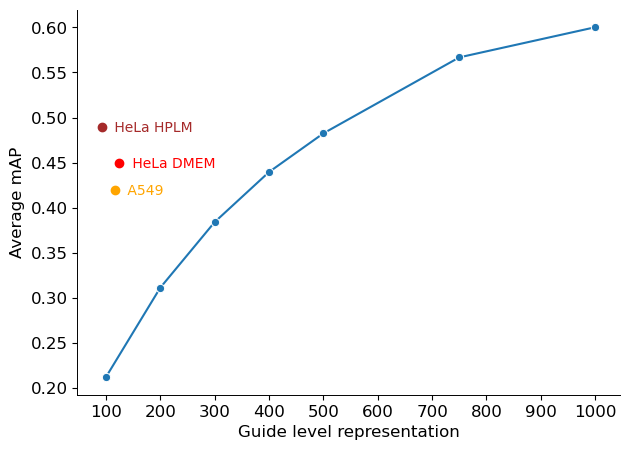

In [35]:
ys = []
for n in subsample_ns:
    y = [i[1] for i in rep_results[n] if i[1]]
    ys.append(np.mean(y))

mpl.rc('axes', linewidth=0.7)
mpl.rc('ytick', labelsize=12)
mpl.rc('xtick', labelsize=12)

fig, ax = plt.subplots(figsize=(7,5))

ax = sns.lineplot(x=subsample_ns, y=ys, errorbar=None, style=1, markers=True, legend=False)
ax.set_title('',size=14)
ax.set_xlabel('Guide level representation',size=12)
ax.set_ylabel('Average mAP',size=12)
ax.set_xticks(range(0,1001,100))

# draw reference lines for screen data
#plt.axvline(x=117, color = 'orange', linestyle='dashed', label='A549')
A549_x = [117]
A549_y = [0.42]
plt.plot(A549_x, A549_y, marker="o", markersize=6, markeredgecolor="orange", markerfacecolor="orange")
plt.text(A549_x[0]+15, A549_y[0]-0.006,' A549',color='orange')
#plt.axvline(x=125, color = 'red', linestyle='dashed', label='HeLa DMEM')
HeLa_DMEM_x = [125]
HeLa_DMEM_y = [0.45]
plt.plot(HeLa_DMEM_x, HeLa_DMEM_y, marker="o", markersize=6, markeredgecolor="red", markerfacecolor="red")
plt.text(HeLa_DMEM_x[0]+15, HeLa_DMEM_y[0]-0.006, ' HeLa DMEM',color='red')
#plt.axvline(x=93, color = 'brown', linestyle='dashed', label='HeLa HPLM')
HeLa_HPLM_x = [93]
HeLa_HPLM_y = [0.49]
plt.plot(HeLa_HPLM_x, HeLa_HPLM_y, marker="o", markersize=6, markeredgecolor="brown", markerfacecolor="brown")
plt.text(HeLa_HPLM_x[0]+15, HeLa_HPLM_y[0]-0.006,' HeLa HPLM',color = 'brown')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(output_folder,'figure_panels','Funk_et_al_2022_subsample_average_mAP.png'),dpi = 300,bbox_inches='tight')
plt.show()